In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
%matplotlib inline
!pip install seaborn
# install seaborn if not installed
import seaborn as sns
# imported libraries.

In [2]:
def get_exchanges():
    res = requests.get(
        f'https://api.cryptowat.ch/exchanges'
    )
    df = pd.DataFrame(res.json()['result'])
    return df.loc[df.loc[:,'active'] == True,'symbol'].tolist()
    
def get_data(token):
    exchanges = [x for x in get_exchanges() if x != 'coinbase-pro']
    res = requests.get(
        f'https://api.cryptowat.ch/markets/coinbase-pro/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        }
    )
    
    while res.ok == False: # Added this block to ensure data can be pulled. 
        ex = exchanges[0]
        res = requests.get(
            f'https://api.cryptowat.ch/markets/{ex}/{token}usd/ohlc',
            params={
                'periods': '3600',
                'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
            }
        )
        exchanges.pop(0)

    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

In [3]:
tokens = ['ETH', 'SOL', 'AVAX', 'USDT', 'FLOW']
dfs = [get_data(tok) for tok in tokens]
df_base = pd.concat(get_data(token) for token in tokens)
df_base.head(10)

,ts,open,high,low,close,volume,volumeUSD,token
0,2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH
1,2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH
2,2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH
3,2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH
4,2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH
5,2021-11-22 05:00:00,4168.35,4186.49,4151.32,4158.06,3897.508536,1.625787e+07,ETH
6,2021-11-22 06:00:00,4157.70,4187.42,4128.04,4187.42,5802.716761,2.415259e+07,ETH
7,2021-11-22 07:00:00,4187.67,4189.52,4163.70,4182.49,3299.589361,1.379359e+07,ETH
8,2021-11-22 08:00:00,4182.54,4220.48,4180.13,4190.73,3316.448902,1.394386e+07,ETH
9,2021-11-22 09:00:00,4191.40,4214.85,4188.64,4200.91,2318.602012,9.739035e+06,ETH


In [4]:
# sort by volumnUSD descending 
df_base.sort_values(by = 'volumeUSD', ascending=False, inplace=True)
df_base


,ts,open,high,low,close,volume,volumeUSD,token
294,2021-12-04 06:00:00,4022.660,4038.800,3575.000,3884.540,97097.417492,3.702769e+08,ETH
285,2021-12-03 21:00:00,4229.090,4229.090,4035.000,4212.340,51723.840085,2.147795e+08,ETH
281,2021-12-03 17:00:00,4469.680,4469.680,4320.000,4344.510,44978.935447,1.973315e+08,ETH
105,2021-11-26 09:00:00,4347.500,4347.510,4005.000,4102.940,44525.053932,1.846590e+08,ETH
209,2021-11-30 17:00:00,4617.000,4673.760,4550.000,4559.990,35939.429206,1.657022e+08,ETH
...,...,...,...,...,...,...,...,...
368,2021-12-07 08:00:00,9.963,10.002,9.957,9.961,232.031147,2.313337e+03,FLOW
268,2021-12-03 04:00:00,12.014,12.071,12.014,12.054,178.652845,2.153556e+03,FLOW
276,2021-12-03 12:00:00,12.174,12.180,12.124,12.127,166.769965,2.028609e+03,FLOW
139,2021-11-27 19:00:00,11.931,11.935,11.919,11.919,145.926810,1.741454e+03,FLOW


In [5]:
# add column calculating close price ratio between ETH and SOL
filt_ETHandSOL = (df_base.loc[:,'token'] == 'ETH') | (df_base.loc[:,'token'] == 'SOL')
SOL_ETH = df_base.loc[filt_ETHandSOL,:].groupby('ts').apply(lambda x : (x.sort_values('token')).loc[:,'close'].pct_change().iloc[1]+1)
SOL_ETH.name = 'SOL/ETH'
if 'SOL/ETH' in df_base.columns:
    df_base.drop('SOL/ETH', axis = 1, inplace=True)
df_base = df_base.set_index('ts').join(SOL_ETH, how = 'outer').sort_values('volumeUSD', ascending = False).reset_index()
df_base


,ts,open,high,low,close,volume,volumeUSD,token,SOL/ETH
0,2021-12-04 06:00:00,4022.660,4038.800,3575.000,3884.540,97097.417492,3.702769e+08,ETH,0.051072
1,2021-12-03 21:00:00,4229.090,4229.090,4035.000,4212.340,51723.840085,2.147795e+08,ETH,0.051327
2,2021-12-03 17:00:00,4469.680,4469.680,4320.000,4344.510,44978.935447,1.973315e+08,ETH,0.050504
3,2021-11-26 09:00:00,4347.500,4347.510,4005.000,4102.940,44525.053932,1.846590e+08,ETH,0.046449
4,2021-11-30 17:00:00,4617.000,4673.760,4550.000,4559.990,35939.429206,1.657022e+08,ETH,0.046137
...,...,...,...,...,...,...,...,...,...
2280,2021-12-07 08:00:00,9.963,10.002,9.957,9.961,232.031147,2.313337e+03,FLOW,0.045834
2281,2021-12-03 04:00:00,12.014,12.071,12.014,12.054,178.652845,2.153556e+03,FLOW,0.051202
2282,2021-12-03 12:00:00,12.174,12.180,12.124,12.127,166.769965,2.028609e+03,FLOW,0.051499
2283,2021-11-27 19:00:00,11.931,11.935,11.919,11.919,145.926810,1.741454e+03,FLOW,0.047598


In [6]:
# Change column names "volume" --> "volumeBase", 'volumeUSD' --> "volumeTerm"
df_base.rename(columns={'volume':'volumeBase', 'volumeUSD':'volumeTerm'}, inplace = True)
df_base

,ts,open,high,low,close,volumeBase,volumeTerm,token,SOL/ETH
0,2021-12-04 06:00:00,4022.660,4038.800,3575.000,3884.540,97097.417492,3.702769e+08,ETH,0.051072
1,2021-12-03 21:00:00,4229.090,4229.090,4035.000,4212.340,51723.840085,2.147795e+08,ETH,0.051327
2,2021-12-03 17:00:00,4469.680,4469.680,4320.000,4344.510,44978.935447,1.973315e+08,ETH,0.050504
3,2021-11-26 09:00:00,4347.500,4347.510,4005.000,4102.940,44525.053932,1.846590e+08,ETH,0.046449
4,2021-11-30 17:00:00,4617.000,4673.760,4550.000,4559.990,35939.429206,1.657022e+08,ETH,0.046137
...,...,...,...,...,...,...,...,...,...
2280,2021-12-07 08:00:00,9.963,10.002,9.957,9.961,232.031147,2.313337e+03,FLOW,0.045834
2281,2021-12-03 04:00:00,12.014,12.071,12.014,12.054,178.652845,2.153556e+03,FLOW,0.051202
2282,2021-12-03 12:00:00,12.174,12.180,12.124,12.127,166.769965,2.028609e+03,FLOW,0.051499
2283,2021-11-27 19:00:00,11.931,11.935,11.919,11.919,145.926810,1.741454e+03,FLOW,0.047598


In [7]:
# Fat table
fat_table = df_base.pivot_table(values = 'close', columns = 'token', index = 'ts')
fat_table

token,AVAX,ETH,FLOW,SOL,USDT
ts,,,,,
2021-11-22 00:00:00,128.67,4262.99,14.150,230.785,1.0012
2021-11-22 01:00:00,134.85,4234.37,13.621,226.000,1.0013
2021-11-22 02:00:00,132.54,4217.89,13.753,227.037,1.0012
2021-11-22 03:00:00,133.38,4193.47,13.652,223.117,1.0011
2021-11-22 04:00:00,136.29,4168.35,13.581,220.652,1.0009
...,...,...,...,...,...
2021-12-10 20:00:00,84.35,4017.67,9.199,173.710,1.0004
2021-12-10 21:00:00,84.67,4050.54,9.115,175.550,1.0004
2021-12-10 22:00:00,84.48,3995.71,8.824,173.560,1.0003


Consider that "pd.df.pct_change()" gives $\frac{\displaystyle P_t-P_{t-1}}{\displaystyle P_{t-1}}$ column,
and $\displaystyle \frac{P_t}{P_{t-1}}=\frac{P_t-P_{t-1}}{P_{t-1}}+1$ 

In [8]:
# Compute log returns
# P_t - 
log_returns = fat_table.apply(lambda x : np.log(x.pct_change()+1))
log_returns

token,AVAX,ETH,FLOW,SOL,USDT
ts,,,,,
2021-11-22 00:00:00,NaN,NaN,NaN,NaN,NaN
2021-11-22 01:00:00,0.046912,-0.006736,-0.038102,-0.020952,0.0001
2021-11-22 02:00:00,-0.017279,-0.003900,0.009644,0.004578,-0.0001
2021-11-22 03:00:00,0.006318,-0.005806,-0.007371,-0.017417,-0.0001
2021-11-22 04:00:00,0.021583,-0.006008,-0.005214,-0.011109,-0.0002
...,...,...,...,...,...
2021-12-10 20:00:00,0.008692,0.008145,0.009612,0.011522,0.0001
2021-12-10 21:00:00,0.003787,0.008148,-0.009173,0.010537,0.0000
2021-12-10 22:00:00,-0.002247,-0.013629,-0.032446,-0.011401,-0.0001


In [9]:
# Compute correlations between tokens

corr = log_returns.corr()
corr

token,AVAX,ETH,FLOW,SOL,USDT
token,,,,,
AVAX,1.000000,0.635958,0.384601,0.619799,-0.026256
ETH,0.635958,1.000000,0.567897,0.736784,-0.136331
FLOW,0.384601,0.567897,1.000000,0.436664,-0.206026
SOL,0.619799,0.736784,0.436664,1.000000,0.110350
USDT,-0.026256,-0.136331,-0.206026,0.110350,1.000000


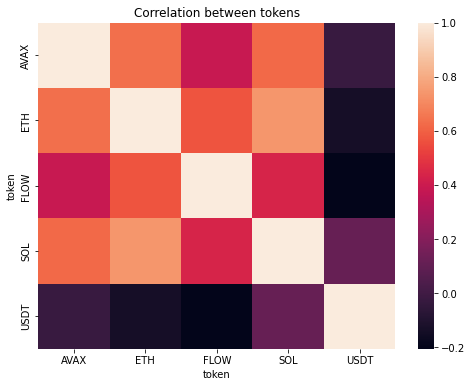

In [10]:
# Visualization 

plot = 'sns'
if plot == 'sns':
    plt.figure(figsize = [8,6])
    sns.heatmap(corr)
    plt.title('Correlation between tokens')
else:
    fig, ax = plt.subplots()
    plt.imshow(corr, cmap='cool', interpolation='nearest')
    ax.set_xticklabels([0]+[x for x in corr.columns])
    ax.set_yticklabels([0]+[x for x in corr.index])
    
    